# Image Colorization using DCGAN

Image colorization is a fascinating process that involves adding color to grayscale images, transforming them from black-and-white to vibrant, colored versions. This technique has significant applications in various fields, including restoring historical photographs, enhancing medical imaging, and adding aesthetic value to artistic works. By leveraging advanced algorithms and deep learning models, modern colorization methods can automatically predict and apply appropriate colors based on context and learned patterns from large datasets of colored images.

### GAN

Generative Adversarial Networks (GANs) are a revolutionary class of machine learning frameworks. They consist of two neural networks, the generator and the discriminator, which engage in a dynamic, adversarial process. The generator creates data samples, such as images, attempting to mimic real data, while the discriminator evaluates these samples, distinguishing between real and generated data. Through this iterative game, both networks improve, resulting in highly realistic synthetic data. GANs have found applications across various fields, from creating art and enhancing medical imaging to augmenting data for machine learning models, significantly advancing the capabilities of AI in generating and understanding complex data.

<center>
    <img src="./images/gan-architecture.jpg" width="50%"/>
</center>

### GAN for Image Colorization

Generative Adversarial Networks (GANs) have significantly advanced the field of image colorization, transforming grayscale images into vibrant, lifelike color images. In this context, the generator network is tasked with predicting and applying appropriate colors to the grayscale input, while the discriminator network evaluates the colorized images against real colored images to ensure realism and coherence. This adversarial training process helps the generator learn to produce highly realistic and contextually accurate colors.

GAN-based colorization models leverage large datasets of colored images to learn complex color distributions and relationships between different image regions and objects. The result is often a colorized image that not only looks plausible but also captures the subtle nuances of the original scene. Applications of GANs in image colorization include restoring historical photographs, enhancing artistic works, and improving visual quality in various multimedia applications. By providing a robust framework for automated colorization, GANs have opened new possibilities in both creative and technical fields, pushing the boundaries of what can be achieved with AI in image processing.

### Encoder/Decoder Model
<center>
    <img src="./images/encoder_decoder.png" width="50%"/>
</center>

#### Encoder Model
The encoder model in neural networks serves a critical function by compressing input data into a more manageable, lower-dimensional latent space representation. This compression process involves several layers, typically convolutional in the case of image data, which progressively distill the input's essential features. For instance, when processing a grayscale image of a busy street scene with buildings, cars, and people, the encoder captures key attributes such as edges, textures, and object outlines. By reducing the image's dimensionality, the encoder filters out noise and redundancy, focusing on the most relevant details. This compact representation, or latent vector, retains the core characteristics of the original image, making it easier to process and transform in subsequent stages of the model. The efficiency and effectiveness of the encoder are vital for a wide range of tasks, including image recognition, feature extraction, and dimensionality reduction.

#### Decoder Model

The decoder model complements the encoder by reconstructing the compressed latent space representation back into a full-scale image or a transformed version of the original input. In the context of image colorization, the decoder receives the latent vector produced by the encoder and processes it through layers designed to increase the spatial dimensions and add color. This typically involves transposed convolutional layers that gradually restore the image's size while applying learned color patterns to different regions. For example, the decoder would interpret the latent vector of the grayscale street scene and predict realistic colors for buildings, cars, and people. The result is a vibrant, colorized image where buildings might display shades of brown and gray, cars appear in colors like red and blue, and people are depicted with natural skin tones and clothing hues. The decoder's ability to generate high-quality, detailed outputs from compact representations is essential for applications such as image colorization, super-resolution, and various forms of data synthesis. Together, the encoder and decoder enable powerful transformations, making sophisticated image processing tasks both feasible and effective.

### U-net Architecture

The U-Net architecture is a powerful and versatile model designed primarily for biomedical image segmentation, but it has found applications across various image processing tasks due to its efficiency and effectiveness. U-Net features a unique, symmetric, U-shaped structure that consists of a contracting path (encoder) and an expanding path (decoder). The encoder path captures context and compresses the input image through successive layers of convolution and max-pooling, reducing the spatial dimensions while increasing feature depth. Conversely, the decoder path performs upsampling and combines these features with corresponding layers from the encoder via skip connections, which help retain spatial information lost during downsampling. This architecture allows U-Net to precisely localize features and generate detailed segmentation maps. Its ability to handle small datasets and produce high-resolution outputs with fine-grained details makes U-Net particularly well-suited for medical imaging tasks, such as detecting tumors or segmenting organs, and has inspired numerous adaptations in other fields of computer vision.

<center>
    <img src="./images/unet.png" width="50%"/>
</center>

## Image Colorization using U-Net

In [1]:
# importing necessary packages
import os
import glob
import time

import mlflow

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch import nn, optim

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader

from pathlib import Path

from PIL import Image

from tqdm.notebook import tqdm

import cv2

from skimage.color import rgb2lab, lab2rgb

In [2]:
print(torch.__version__)

2.3.0+cu121


In [3]:
# Checking the availability of accelerator
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [4]:
# image dimension to be resized to
IMAGE_DIM = 256

In [5]:
# path to the images
dataset_path = "Dataset/images"

# accessing the image using glob
paths = glob.glob(dataset_path + "/*.jpg") 

# for reproducibility
np.random.seed(123)

# choosing 9 images randomly
paths_subset = np.random.choice(paths, 9, replace=False) 

paths_subset

array(['Dataset/images\\image_1834.jpg', 'Dataset/images\\image_981.jpg',
       'Dataset/images\\image_386.jpg', 'Dataset/images\\image_1405.jpg',
       'Dataset/images\\image_600.jpg', 'Dataset/images\\image_441.jpg',
       'Dataset/images\\image_1659.jpg', 'Dataset/images\\image_1569.jpg',
       'Dataset/images\\image_1987.jpg'], dtype='<U29')

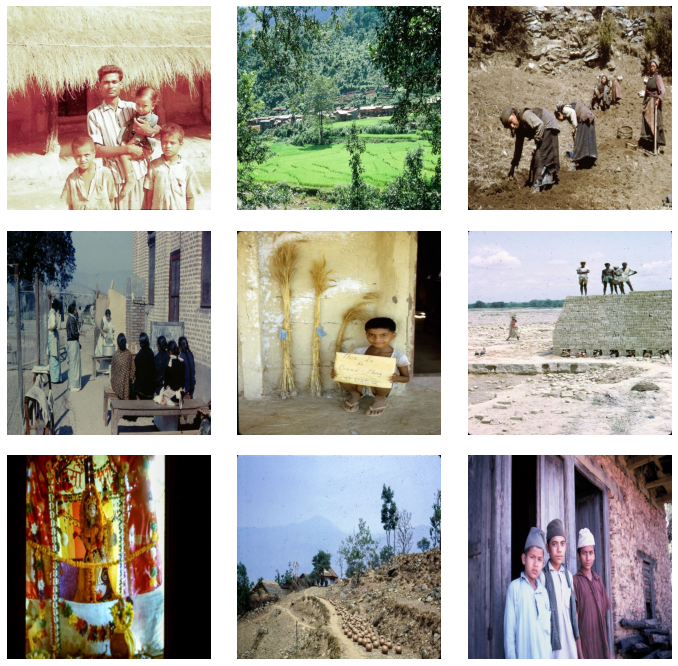

In [6]:
_, axes = plt.subplots(3, 3, figsize=(12, 12))
for ax, img_path in zip(axes.flatten(), paths_subset):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

# Adjust padding between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1) 

plt.show()

#### Creating a DataLoader

To fetch the images in batch, dataloader can be used, and pytorch has provided a dataloader library for this.

In [7]:
# Dimension to which images will be resized
IMAGE_DIM = 256  

class ImageDataset(Dataset):
    """
    Custom dataset class for loading and preprocessing images.
    
    Parameters:
    ------
        dataframe: (pd.DataFrame)
            DataFrame containing image paths and metadata.
        
        split: (str)
            Dataset split type ('train' or 'val').
        
        transforms: (torchvision.transforms.Compose or torchvision.transforms.Resize)
            Transformations to apply to images.
        
        size: (int)
            Size to which images will be resized.
    """
    
    def __init__(self, dataframe: pd.DataFrame, split: str='train'):
        """
        Initializes the dataset, sets up transformations based on the split type, and stores the DataFrame.

        Parameters:
        ------
            dataframe: (pd.DataFrame)
                DataFrame containing image paths and metadata.
            
            split: (str)
                Dataset split type ('train' or 'val'). Default is 'train'.
        """
        if split == 'train':
            # Transformations for training: resize and random horizontal flip for augmentation
            self.transforms = transforms.Compose([
                transforms.Resize((IMAGE_DIM, IMAGE_DIM), Image.BICUBIC),
                transforms.RandomHorizontalFlip(),
            ])
        elif split == 'val':
            # Transformation for validation: only resize
            self.transforms = transforms.Resize((IMAGE_DIM, IMAGE_DIM), Image.BICUBIC)
        
        # Store the split type
        self.split = split  

        # Store the image dimension
        self.size = IMAGE_DIM 

        # Store the dataframe containing metadata 
        self.dataframe = dataframe  


    def __getitem__(self, idx):
        """
        Retrieves an image and its corresponding transformations and conversions.

        Parameters:
        ------
            idx: (int or torch.Tensor)
                Index of the image to retrieve.

        Returns:
            dict: Dictionary containing the Lightness and ab channels of the image.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()  # Convert tensor index to list

        # Read the image using OpenCV
        image = cv2.imread(str(self.dataframe.iloc[idx].path))

        # Convert the image from BGR (OpenCV format) to RGB (PIL format)
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        # Apply transformations to the image
        img = self.transforms(image)
        img = np.array(img)  # Convert the PIL image to a NumPy array

        # Convert the RGB image to L*a*b color space
        img_lab = rgb2lab(img).astype("float32")
        img_lab = transforms.ToTensor()(img_lab)  # Convert the L*a*b image to a tensor

        # Normalize the Lightness channel to be between -1 and 1
        Lightness_channel = img_lab[[0], ...] / 50.0 - 1.0

        # Normalize the a and b channels to be between -1 and 1
        ab_channel = img_lab[[1, 2], ...] / 110.0

        # Return the Lightness and ab channels as a dictionary
        return {'L': Lightness_channel, 'ab': ab_channel}


    def __len__(self):
        """
        Returns the number of samples in the dataset.

        Returns:
            int: Number of samples in the dataset.
        """
        # Return the length of the dataframe
        return len(self.dataframe)  


In [8]:
def make_dataloaders(batch_size=8, n_workers=0, pin_memory=True, **kwargs):
    """
    Creates a DataLoader for the ImageDataset.

    Args:
        batch_size (int): Number of samples per batch to load. Default is 16.
        n_workers (int): How many subprocesses to use for data loading. Default is 0.
        pin_memory (bool): If True, the data loader will copy Tensors into CUDA pinned memory before returning them. Default is True.
        **kwargs: Additional arguments to pass to the ImageDataset class.

    Returns:
        DataLoader: DataLoader for the ImageDataset.
    """
    # Initialize the dataset using the provided arguments
    dataset = ImageDataset(**kwargs)
    
    # Create a DataLoader for the dataset
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers, pin_memory=pin_memory)
    
    # Return the DataLoader
    return dataloader

In [9]:
# Defining the path to the dataset
dataset_folder: str = "./Dataset/images"

# Initializing empty lists to store filename and corresponding labels
filenames: list = []

# using glob to access the path of image
image_paths = glob.glob(dataset_folder + "/*.jpg")

# Creating the dataframe to store the filename and its correspondin label
df: pd.DataFrame = pd.DataFrame({
        "path": list(map(lambda x: Path(x), image_paths))
    })

# Displaying the dataset
display(df.head())

,path
0,Dataset\images\image_1.jpg
1,Dataset\images\image_10.jpg
2,Dataset\images\image_100.jpg
3,Dataset\images\image_1000.jpg
4,Dataset\images\image_1001.jpg


In [10]:
# Splitting the dataset into train set and test set
from sklearn.model_selection import train_test_split

# Splitting the dataset into 80/20 train/test set
train_set, test_set = train_test_split(df, test_size=0.2)

print(f"Number of train dataset: {len(train_set)}")
print(f"Number of test dataset: {len(test_set)}")

Number of train dataset: 1660
Number of test dataset: 415


In [11]:
# train dataloader
train_dataloader = make_dataloaders(dataframe=train_set, split="train")

# validation dataloader
test_dataloader = make_dataloaders(dataframe=test_set, split="val")

In [12]:
data = next(iter(train_dataloader))
Ls, abs_ = data['L'], data['ab']

In [13]:
print(f"Shape of the Lightness: {Ls.shape}")
print(f"Shape of the ab: {abs_.shape}")

Shape of the Lightness: torch.Size([8, 1, 256, 256])
Shape of the ab: torch.Size([8, 2, 256, 256])


In [14]:
print(f"Length of the train set: {len(train_dataloader)}")
print(f"Length of the test set: {len(test_dataloader)}")

Length of the train set: 208
Length of the test set: 52


In [15]:
class MaxPool(nn.Module):
    def __init__(self, kernel_size: int, stride: int=None, padding: int=0):
        """
        This function initializes the parameters for a maxpool layer

        Parameters
        ------------
            kernel_size : int
            window height and width for the maxpooling window

            stride : int
            the stride of the window. Default value is kernel_size

            padding: int
            implicit zero padding to be added on both sides
        """
        super(MaxPool, self).__init__()
        self.kernel_size = kernel_size
        self.stride = kernel_size if stride is None else stride
        self.padding = padding


    def forward(self, x: torch.tensor): 
        """
        This function performs max-pool operation on the input

        Parameters
        ------------
            x : tensor, float32
            Input image to the convolution layer

        Returns
        ------------
            x : tensor, float32
            max-pooled output from the last layer
        """
        # Returning the max pool operation
        return F.max_pool2d(x, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)

In [16]:
class Dense(nn.Module):
    def __init__(self, in_features: int, out_features: int):
        """
        This function initializes the parameters for a dense layer
        Parameters
        ------------- 
            in_features : int
            shape of the input to the dense layer

            out_features : int
            number of units in the dense layer
        """
        super(Dense, self).__init__()
        self.in_features = in_features
        self.out_features =  out_features
        
        self.weight = nn.Parameter(
            torch.nn.init.xavier_uniform_(
                torch.empty(
                    (self.in_features, self.out_features),
                    requires_grad=True,
                )
            )
        )
        self.bias = nn.Parameter(
            torch.zeros((self.out_features,), requires_grad=True)
        )

    def forward(self, x: torch.tensor):
        """
        This function performs dense operation on the input
        Parameters
        ------------
            x : tensor, float32
            Input flattened image to the convolution layer

        Returns
        ------------
            x : tensor, float32
            linear operation output from the last layer
        """
        # Returning the matrix multiplication
        return torch.mm(x, self.weight) + self.bias


In [17]:
class Reshape(nn.Module):
    """
    Reshape the input to target shape
    """
    def __init__(self, target_shape: tuple):
        super(Reshape, self).__init__()
        self.target_shape = target_shape
    
    def forward(self, inputs: torch.tensor):
        return inputs.reshape((-1, *self.target_shape))

In [18]:
class BatchNormalization(nn.Module):
    def __init__(self, num_channels: int):
        super(BatchNormalization, self).__init__()
        self.batch_norm = nn.BatchNorm2d(num_channels)

    def forward(self, x: torch.tensor):
        # Reshape the input if it's not in 4D (batch_size, channels, height, width)
        if len(x.shape) == 2:
            x = x.unsqueeze(1)  # Add a singleton dimension for channels

        # Perform batch normalization
        x = self.batch_norm(x)

        return x

#### Creating a Unet Architecture

In [19]:
class UnetBlock(nn.Module):
    """
    U-Net block for the U-Net architecture.

    Args:
        nf (int): Number of filters for the upsampling path.
        ni (int): Number of filters for the downsampling path.
        submodule (nn.Module, optional): Submodule for nested U-Net structure. Default is None.
        input_c (int, optional): Number of input channels. Default is None.
        dropout (bool, optional): Whether to apply dropout. Default is False.
        innermost (bool, optional): Whether this is the innermost layer. Default is False.
        outermost (bool, optional): Whether this is the outermost layer. Default is False.
    """
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super(UnetBlock, self).__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4, stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = BatchNormalization(ni)  
        uprelu = nn.ReLU(True)
        upnorm = BatchNormalization(nf)  
        
        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4, stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4, stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4, stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
    
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)


In [20]:
class Unet(nn.Module):
    """
    U-Net architecture.

    Args:
        input_c (int, optional): Number of input channels. Default is 1.
        output_c (int, optional): Number of output channels. Default is 2.
        n_down (int, optional): Number of downsampling steps. Default is 8.
        num_filters (int, optional): Number of filters for the convolution layers. Default is 64.
    """
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)
    
    
    def forward(self, x):
        return self.model(x)

In [21]:
# testin the output shape for generator

# Creating a U-Net model with 1 input channel and 2 output channels
model = Unet(input_c=1, output_c=2)

# Creating a random tensor with shape (batch_size, input_channels, height, width)
input_tensor = torch.randn(1, 1, 256, 256)  # Batch size of 1, 1 input channel, 256x256 image

# Applying the U-Net model
output_tensor = model(input_tensor)

# Printing the shape of the output tensor
print(output_tensor.shape)  # Should match the shape (1, 2, 256, 256)

torch.Size([1, 2, 256, 256])


In [22]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, norm=True, act=True):
        """
        Initializes a convolutional block with optional batch normalization and activation.

        Parameters
        ------------
        in_channels : int
            Number of input channels.

        out_channels : int
            Number of output channels.

        kernel_size : int
            Size of the convolution kernel.

        stride : int
            Stride for the convolution.

        padding : int
            Padding for the convolution.

        norm : bool
            Whether to include batch normalization.

        act : bool
            Whether to include activation (LeakyReLU).
        """
        super(ConvBlock, self).__init__()
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=not norm)]
        if norm:
            layers.append(nn.BatchNorm2d(out_channels))
        if act:
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass through the convolutional block.

        Parameters
        ------------
        x : torch.Tensor
            Input tensor.

        Returns
        ------------
        torch.Tensor
            Output tensor.
        """
        return self.block(x)

In [23]:
class PatchDiscriminator(nn.Module):
    """
    PatchGAN discriminator for U-Net architecture.

    Args:
        input_c (int): Number of input channels.
        num_filters (int, optional): Number of filters for the convolution layers. Default is 64.
        n_down (int, optional): Number of downsampling steps. Default is 3.
    """
    def __init__(self, input_c: int, num_filters: int = 64, n_down: int = 3):
        super(PatchDiscriminator, self).__init__()
        # Initial layer without normalization
        model = [self.get_layers(input_c, num_filters, norm=False)]
        
        # Intermediate layers with increasing number of filters
        for i in range(n_down):
            stride = 1 if i == (n_down - 1) else 2
            model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=stride)]
        
        # Final layer without normalization or activation
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)]
        
        self.model = nn.Sequential(*model)


    def get_layers(self, ni: int, nf: int, k: int = 4, s: int = 2, p: int = 1, norm: bool = True, act: bool = True) -> nn.Sequential:
        """
        Creates a sequence of convolutional layers.

        Args:
            ni (int): Number of input channels.
            nf (int): Number of output channels.
            k (int, optional): Kernel size. Default is 4.
            s (int, optional): Stride. Default is 2.
            p (int, optional): Padding. Default is 1.
            norm (bool, optional): Whether to use batch normalization. Default is True.
            act (bool, optional): Whether to use activation (LeakyReLU). Default is True.

        Returns:
            nn.Sequential: Sequential container with the specified layers.
        """
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]  # Convolutional layer
        if norm:
            layers += [BatchNormalization(nf)]  # Custom BatchNormalization
        if act:
            layers += [nn.LeakyReLU(0.2, True)]  # LeakyReLU activation
        return nn.Sequential(*layers)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the PatchGAN discriminator.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        return self.model(x)


In [24]:
# Testing the output shape for discriminator

# Creating a PatchDiscriminator model with 3 input channels
discriminator = PatchDiscriminator(input_c=3)

# Creating a random tensor with shape (batch_size, input_channels, height, width)
input_tensor = torch.randn(1, 3, 256, 256)  # Batch size of 1, 3 input channels, 256x256 image

# Applying the PatchDiscriminator model
output_tensor = discriminator(input_tensor)

# Printing the shape of the output tensor
print(output_tensor.shape)  

torch.Size([1, 1, 30, 30])


In [25]:
class GANLoss(nn.Module):
    """
    Loss function for GANs, supporting both vanilla and LSGAN modes.

    Args:
        gan_mode (str, optional): The type of GAN loss to use ('vanilla' or 'lsgan'). Default is 'vanilla'.
        real_label (float, optional): The label value for real samples. Default is 1.0.
        fake_label (float, optional): The label value for fake samples. Default is 0.0.
    """
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super(GANLoss, self).__init__()
        # Register real and fake label buffers
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        
        # Choose the loss function based on gan_mode
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
        else:
            raise ValueError(f"gan_mode '{gan_mode}' not recognized")


    def get_labels(self, preds: torch.Tensor, target_is_real: bool) -> torch.Tensor:
        """
        Get the labels for real or fake samples.

        Args:
            preds (torch.Tensor): Predictions from the discriminator.
            target_is_real (bool): Whether the target is real or fake.

        Returns:
            torch.Tensor: Labels matching the shape of preds.
        """
        # Select the appropriate label based on target_is_real
        labels = self.real_label if target_is_real else self.fake_label
        return labels.expand_as(preds)


    def forward(self, preds: torch.Tensor, target_is_real: bool) -> torch.Tensor:
        """
        Calculate the GAN loss.

        Args:
            preds (torch.Tensor): Predictions from the discriminator.
            target_is_real (bool): Whether the target is real or fake.

        Returns:
            torch.Tensor: Calculated loss.
        """
        # Get the correct labels for the current target (real or fake)
        labels = self.get_labels(preds, target_is_real)
        # Compute the loss
        loss = self.loss(preds, labels)
        return loss

In [26]:
# testing the ganloss

# Example predictions from a discriminator
preds = torch.randn(4, 1)  # Batch size of 4, single prediction per sample

# Initialize GANLoss for 'vanilla' mode
gan_loss_vanilla = GANLoss(gan_mode='vanilla')

# Calculate loss for real images
loss_real = gan_loss_vanilla(preds, target_is_real=True)
print(f"Vanilla GAN loss for real images: {loss_real.item()}")

# Calculate loss for fake images
loss_fake = gan_loss_vanilla(preds, target_is_real=False)
print(f"Vanilla GAN loss for fake images: {loss_fake.item()}")

# Initialize GANLoss for 'lsgan' mode
gan_loss_lsgan = GANLoss(gan_mode='lsgan')

# Calculate loss for real images
loss_real_lsgan = gan_loss_lsgan(preds, target_is_real=True)
print(f"LSGAN loss for real images: {loss_real_lsgan.item()}")

# Calculate loss for fake images
loss_fake_lsgan = gan_loss_lsgan(preds, target_is_real=False)
print(f"LSGAN loss for fake images: {loss_fake_lsgan.item()}")

Vanilla GAN loss for real images: 1.015326738357544
Vanilla GAN loss for fake images: 0.7968980669975281
LSGAN loss for real images: 3.4179184436798096
LSGAN loss for fake images: 1.981061339378357


In [27]:
def init_weights(net, init='norm', gain=0.02):
    """
    Initialize weights for the network.

    Args:
        net (torch.nn.Module): The network to initialize.
        init (str, optional): The initialization method. Can be 'norm', 'xavier', or 'kaiming'. Default is 'norm'.
        gain (float, optional): The gain value for initialization. Default is 0.02.
    """
    def init_func(m):
        """
        Initialization function to apply to each module in the network.

        Args:
            m (torch.nn.Module): The module to initialize.
        """
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
    
    net.apply(init_func)
    print(f"Model initialized with {init} initialization")
    
    return net

In [28]:
def init_model(model, device):
    """
    Initialize the model and move it to the specified device.

    Args:
        model (torch.nn.Module): The model to initialize.
        device (str or torch.device): The device to move the model to.

    Returns:
        torch.nn.Module: The initialized and moved model.
    """
    model = model.to(device)
    model = init_weights(model)
    
    return model

In [29]:
# testing the model initialization
# Dummy model
class ExampleModel(nn.Module):
    def __init__(self):
        super(ExampleModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
    
    def forward(self, x):
        x = self.bn1(self.conv1(x))
        x = self.bn2(self.conv2(x))
        
        return x

model = ExampleModel()
model = init_model(model, device)

# Print model to verify initialization
print(model)


Model initialized with norm initialization
ExampleModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [30]:
class GANModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, 
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super(GANModel, self).__init__()
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        
        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)

        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)

        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss().to(self.device)
        
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))

    
    def set_requires_grad(self, model: nn.Module, requires_grad: bool = True):
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    
    def setup_input(self, data: dict):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)
        
    
    def forward(self):
        self.fake_color = self.net_G(self.L)

In [31]:
def initialize_network(self, net, default_net):
    """
    Initialize the network and move it to the appropriate device.

    Parameters
    ------------
    net : nn.Module or None
        The network to initialize. If None, the default_net will be used.

    default_net : nn.Module
        The default network to use if net is None.

    Returns
    ------------
    nn.Module
        The initialized network.
    """
    if net is None:
        return init_model(default_net, self.device)
    return net.to(self.device)


GANModel.initialize_network = initialize_network

In [32]:
def compute_discriminator_loss(self):
    fake_image = torch.cat([self.L, self.fake_color], dim=1)
    fake_preds = self.net_D(fake_image.detach())
    self.loss_D_fake = self.GANcriterion(fake_preds, False)

    real_image = torch.cat([self.L, self.ab], dim=1)
    real_preds = self.net_D(real_image)
    self.loss_D_real = self.GANcriterion(real_preds, True)

    self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5


GANModel.compute_discriminator_loss = compute_discriminator_loss

In [33]:
def compute_generator_loss(self):
    fake_image = torch.cat([self.L, self.fake_color], dim=1)
    fake_preds = self.net_D(fake_image)
    self.loss_G_GAN = self.GANcriterion(fake_preds, True)
    self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
    self.loss_G = self.loss_G_GAN + self.loss_G_L1


GANModel.compute_generator_loss = compute_generator_loss

In [34]:
def backward_D(self):
    self.compute_discriminator_loss()
    self.loss_D.backward()


GANModel.backward_D = backward_D

In [35]:
def backward_G(self):
    self.compute_generator_loss()
    self.loss_G.backward()


GANModel.backward_G = backward_G

In [36]:
def optimize(self):
    self.forward()
    
    # Update Discriminator
    self.net_D.train()
    self.set_requires_grad(self.net_D, True)
    self.opt_D.zero_grad()
    self.backward_D()
    self.opt_D.step()
    
    # Update Generator
    self.net_G.train()
    self.set_requires_grad(self.net_D, False)
    self.opt_G.zero_grad()
    self.backward_G()
    self.opt_G.step()


GANModel.optimize = optimize

In [37]:
# Create an instance of the MainModel
model = GANModel()

# Print the architecture of the generator and discriminator
print("Generator (Unet) Architecture:")
print(model.net_G)

print("\nDiscriminator (PatchDiscriminator) Architecture:")
print(model.net_D)

Model initialized with norm initialization
Model initialized with norm initialization
Generator (Unet) Architecture:
Unet(
  (model): UnetBlock(
    (model): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): UnetBlock(
        (model): Sequential(
          (0): LeakyReLU(negative_slope=0.2, inplace=True)
          (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (2): BatchNormalization(
            (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (3): UnetBlock(
            (model): Sequential(
              (0): LeakyReLU(negative_slope=0.2, inplace=True)
              (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
              (2): BatchNormalization(
                (batch_norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
             

In [38]:
class AverageMeter:
    """
    Computes and stores the average and sum of values.
    """
    def __init__(self):
        self.reset()

        
    def reset(self):
        """Resets the meter."""
        self.count, self.avg, self.sum = 0, 0, 0
    
    
    def update(self, val, count=1):
        """
        Updates the meter with a new value.

        Parameters:
            val (float): The new value to be added.
            count (int): The count associated with the value (default is 1).
        """
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

In [39]:
def create_loss_meters():
    """
    Creates a dictionary of AverageMeter instances for different loss types.

    Returns:
        dict: A dictionary containing AverageMeter instances for each loss type.
    """
    loss_meter_dict = {}
    loss_names = ['loss_D_fake', 'loss_D_real', 'loss_D', 'loss_G_GAN', 'loss_G_L1', 'loss_G']
    for loss_name in loss_names:
        loss_meter_dict[loss_name] = AverageMeter()
    return loss_meter_dict

In [40]:
def update_losses(model, loss_meter_dict, count):
    """
    Updates the loss meters based on the current losses of the model.

    Parameters:
        model: The model containing the loss values.
        loss_meter_dict (dict): A dictionary containing loss meters.
        count (int): The count associated with the loss update.
    """
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

In [41]:
def lab_to_rgb(L, ab):
    """
    Converts LAB color space to RGB color space.

    Parameters:
        L (torch.Tensor): Tensor containing the L channel of LAB color space.
        ab (torch.Tensor): Tensor containing the ab channels of LAB color space.

    Returns:
        numpy.ndarray: Array of RGB images.
    """
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1)
    rgb_imgs = lab2rgb(Lab.permute(0, 2, 3, 1).detach().cpu().numpy())
    return rgb_imgs

In [42]:
def visualize(model, data, save=False):
    """
    Visualizes the colorization results.

    Parameters:
        model: The colorization model.
        data: Input data for colorization.
        save (bool): Flag to save the visualization (default is True).
    """
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(8, 15))
    plt.tight_layout()
    # Adjust padding between subplots
    plt.subplots_adjust(wspace=0.1, hspace=0.1) 
    plt.ion()
    for i in range(3):
        ax = plt.subplot(5, 3, i * 3 + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        
        ax = plt.subplot(5, 3, i * 3 + 2)
        ax.imshow(real_imgs[i])
        ax.axis("off")
        
        ax = plt.subplot(5, 3, i * 3 + 3)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
    
    plt.ioff()
    # plt.show()
    plt.close()

    if save:
        fig.savefig(f"colorization_{time.time()}.png")

    return fig


In [43]:
def log_results(loss_meter_dict):
    """
    Logs the average loss values.

    Parameters:
        loss_meter_dict (dict): A dictionary containing loss meters.
    """
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

In [44]:
def save_checkpoint(model, epoch, iteration, path):
    """
    Save model checkpoint.

    Args:
        model: The model to save.
        epoch (int): Current epoch.
        iteration (int): Current iteration.
        path (str): Path to save the checkpoint.
    """
    checkpoint = {
        'epoch': epoch,
        'iteration': iteration,
        'model_state_dict': model.state_dict()
    }
    torch.save(checkpoint, path)

In [45]:
def set_or_create_experiment(experiment_name: str) -> str:
    """
    Create a new mlflow experiment with the given name and artifact location.

    Parameters:
    ----------
    experiment_name: (str)
        The name of the experiment to create.

    Returns:
    -------
    experiment_id: (str)
        The id of the created experiment.
    """
    # creating the experiement
    try:
        experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
    except Exception:
        experiment_id = mlflow.create_experiment(experiment_name)
    finally:
        # set the experiement as the active experiement
        mlflow.set_experiment(experiment_name=experiment_name)

    return experiment_id

In [46]:
def get_mlflow_experiment(
    experiment_id: str = None, experiment_name: str = None
) -> mlflow.entities.Experiment:
    """
    Retrieve the mlflow experiment with the given id or name.

    Parameters:
    ----------
    experiment_id: (str)
        The id of the experiment to retrieve.

    experiment_name: (str)
        The name of the experiment to retrieve.

    Returns:
    -------
    experiment: (mlflow.entities.Experiment)
        The mlflow experiment with the given id or name.
    """
    if experiment_id is not None:
        experiment = mlflow.get_experiment(experiment_id)
    elif experiment_name is not None:
        experiment = mlflow.get_experiment_by_name(experiment_name)
    else:
        raise ValueError(
            """
                Either experiment_id or experiment_name must be provided.
            """
        )

    return experiment

In [47]:
experiment_id = set_or_create_experiment(experiment_name="Image_Colorization_using_GAN")
experiment_id

'954255151145399725'

In [48]:
def register_model(model_name: str, run_id: str, artifact_path: str):
    """
    Register a model.

    Parameters:
    ------
    model_name: (str)
        Name of the model.

    run_id: (str)
        Run ID.

    artifact_path: (str)
        Artifact path.

    return:
    ------
        None.
    """
    # creating the mlflow client
    client = mlflow.tracking.MlflowClient()

    # creating the registry model
    client.create_registered_model(model_name)

    # versioning the model
    client.create_model_version(
        name=model_name, source=f"runs:/{run_id}/{artifact_path}", run_id=run_id
    )

In [49]:
def plot_losses(loss_G_epoch, loss_D_epoch):
    """
    Plot generator and discriminator losses.

    Args:
        loss_G_epoch (list): List of generator losses per epoch.
        loss_D_epoch (list): List of discriminator losses per epoch.
    """
    epochs = range(1, len(loss_G_epoch) + 1)

    fig = plt.figure(figsize=(9, 9))
    
    plt.plot(epochs, loss_G_epoch, label='Generator Loss', color='blue')
    plt.plot(epochs, loss_D_epoch, label='Discriminator Loss', color='red')
    
    plt.title('Generator and Discriminator Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')  # Add legend with labels
    plt.grid(True)
    plt.show()

    return plt

In [50]:
def train_model(model, train_dataloader, epochs=20, display_every=100, checkpoint_dir='checkpoints', checkpoint_every=1000):
    # Create directory for checkpoints if it doesn't exist
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir) 
    
    data = next(iter(test_dataloader))  # Fetch a batch for visualization

    loss_G = []
    loss_D = []

    with mlflow.start_run(run_name="UNet_v1", experiment_id=experiment_id):
        for e in range(epochs):
            loss_G_iteration = []
            loss_D_iteration = []
        
            loss_meter_dict = create_loss_meters()  # Create loss meters
            for i, data in tqdm(enumerate(train_dataloader, 1), total=len(train_dataloader)):
                model.setup_input(data) 
                model.optimize()
                update_losses(model, loss_meter_dict, count=data["L"].size(0))  # Update loss meters

                loss_G_iteration.append(loss_meter_dict["loss_G"].avg)
                loss_D_iteration.append(loss_meter_dict["loss_D"].avg)
                
                # Print and log losses
                # if i % display_every == 0 or i == len(train_dataloader):
                #     print(f"\nEpoch {e+1}/{epochs}")
                #     print(f"Iteration {i}/{len(train_dataloader)}")
                #     log_results(loss_meter_dict)  # Log losses
                    
                # Save model checkpoint
                if i % checkpoint_every == 0 or i == len(train_dataloader):
                    checkpoint_path = os.path.join(checkpoint_dir, f"model_checkpoint_epoch{e+1}_iter{i}.pt")
                    save_checkpoint(model, epoch=e, iteration=i, path=checkpoint_path)

            loss_G.append(np.mean(loss_G_iteration))
            loss_D.append(np.mean(loss_D_iteration))

            # Printing the informations
            print(f"\nEpoch {e+1}/{epochs}")
            print(f"Iteration {i}/{len(train_dataloader)}")
            log_results(loss_meter_dict)  # Log losses

            # Log the visualization figure as an artifact
            fig = visualize(model, data, save=False)  # Generate the visualization figure
            mlflow.log_figure(fig, f"image_epoch_{e+1}.png")  # Log the figure as an artifact

    plot_losses(loss_G, loss_D)

In [51]:
model = GANModel()

Model initialized with norm initialization
Model initialized with norm initialization


  0%|          | 0/208 [00:00<?, ?it/s]


Epoch 1/30
Iteration 208/208
loss_D_fake: 0.56676
loss_D_real: 0.57330
loss_D: 0.57003
loss_G_GAN: 1.19843
loss_G_L1: 8.84352
loss_G: 10.04194


C:\Users\LEGION\AppData\Local\Temp\ipykernel_22040\852575839.py:15: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  rgb_imgs = lab2rgb(Lab.permute(0, 2, 3, 1).detach().cpu().numpy())


  0%|          | 0/208 [00:00<?, ?it/s]


Epoch 2/30
Iteration 208/208
loss_D_fake: 0.48598
loss_D_real: 0.49779
loss_D: 0.49189
loss_G_GAN: 1.60885
loss_G_L1: 9.15685
loss_G: 10.76569


  0%|          | 0/208 [00:00<?, ?it/s]


Epoch 3/30
Iteration 208/208
loss_D_fake: 0.53063
loss_D_real: 0.57464
loss_D: 0.55263
loss_G_GAN: 1.32208
loss_G_L1: 9.35889
loss_G: 10.68097


  0%|          | 0/208 [00:00<?, ?it/s]


Epoch 4/30
Iteration 208/208
loss_D_fake: 0.54852
loss_D_real: 0.59929
loss_D: 0.57390
loss_G_GAN: 1.19829
loss_G_L1: 9.26209
loss_G: 10.46038


  0%|          | 0/208 [00:00<?, ?it/s]


Epoch 5/30
Iteration 208/208
loss_D_fake: 0.54595
loss_D_real: 0.60362
loss_D: 0.57479
loss_G_GAN: 1.19398
loss_G_L1: 9.22178
loss_G: 10.41576


C:\Users\LEGION\AppData\Local\Temp\ipykernel_22040\852575839.py:15: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1147 negative Z values that have been clipped to zero
  rgb_imgs = lab2rgb(Lab.permute(0, 2, 3, 1).detach().cpu().numpy())


  0%|          | 0/208 [00:00<?, ?it/s]


Epoch 6/30
Iteration 208/208
loss_D_fake: 0.55224
loss_D_real: 0.60048
loss_D: 0.57636
loss_G_GAN: 1.18132
loss_G_L1: 9.14674
loss_G: 10.32805


C:\Users\LEGION\AppData\Local\Temp\ipykernel_22040\852575839.py:15: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 214 negative Z values that have been clipped to zero
  rgb_imgs = lab2rgb(Lab.permute(0, 2, 3, 1).detach().cpu().numpy())


  0%|          | 0/208 [00:00<?, ?it/s]


Epoch 7/30
Iteration 208/208
loss_D_fake: 0.55482
loss_D_real: 0.61323
loss_D: 0.58403
loss_G_GAN: 1.15519
loss_G_L1: 9.10604
loss_G: 10.26123


C:\Users\LEGION\AppData\Local\Temp\ipykernel_22040\852575839.py:15: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1188 negative Z values that have been clipped to zero
  rgb_imgs = lab2rgb(Lab.permute(0, 2, 3, 1).detach().cpu().numpy())


  0%|          | 0/208 [00:00<?, ?it/s]


Epoch 8/30
Iteration 208/208
loss_D_fake: 0.54314
loss_D_real: 0.60287
loss_D: 0.57301
loss_G_GAN: 1.16956
loss_G_L1: 9.01658
loss_G: 10.18614


C:\Users\LEGION\AppData\Local\Temp\ipykernel_22040\852575839.py:15: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1442 negative Z values that have been clipped to zero
  rgb_imgs = lab2rgb(Lab.permute(0, 2, 3, 1).detach().cpu().numpy())


  0%|          | 0/208 [00:00<?, ?it/s]


Epoch 9/30
Iteration 208/208
loss_D_fake: 0.54630
loss_D_real: 0.59964
loss_D: 0.57297
loss_G_GAN: 1.17035
loss_G_L1: 8.95671
loss_G: 10.12706


C:\Users\LEGION\AppData\Local\Temp\ipykernel_22040\852575839.py:15: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1024 negative Z values that have been clipped to zero
  rgb_imgs = lab2rgb(Lab.permute(0, 2, 3, 1).detach().cpu().numpy())


  0%|          | 0/208 [00:00<?, ?it/s]


Epoch 10/30
Iteration 208/208
loss_D_fake: 0.55385
loss_D_real: 0.60337
loss_D: 0.57861
loss_G_GAN: 1.16048
loss_G_L1: 8.84437
loss_G: 10.00485


C:\Users\LEGION\AppData\Local\Temp\ipykernel_22040\852575839.py:15: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2987 negative Z values that have been clipped to zero
  rgb_imgs = lab2rgb(Lab.permute(0, 2, 3, 1).detach().cpu().numpy())


  0%|          | 0/208 [00:00<?, ?it/s]


Epoch 11/30
Iteration 208/208
loss_D_fake: 0.54715
loss_D_real: 0.59509
loss_D: 0.57112
loss_G_GAN: 1.16922
loss_G_L1: 8.76364
loss_G: 9.93286


C:\Users\LEGION\AppData\Local\Temp\ipykernel_22040\852575839.py:15: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1354 negative Z values that have been clipped to zero
  rgb_imgs = lab2rgb(Lab.permute(0, 2, 3, 1).detach().cpu().numpy())


  0%|          | 0/208 [00:00<?, ?it/s]


Epoch 12/30
Iteration 208/208
loss_D_fake: 0.55387
loss_D_real: 0.60576
loss_D: 0.57981
loss_G_GAN: 1.15446
loss_G_L1: 8.61370
loss_G: 9.76815


C:\Users\LEGION\AppData\Local\Temp\ipykernel_22040\852575839.py:15: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 746 negative Z values that have been clipped to zero
  rgb_imgs = lab2rgb(Lab.permute(0, 2, 3, 1).detach().cpu().numpy())


  0%|          | 0/208 [00:00<?, ?it/s]


Epoch 13/30
Iteration 208/208
loss_D_fake: 0.55751
loss_D_real: 0.60842
loss_D: 0.58296
loss_G_GAN: 1.16300
loss_G_L1: 8.48154
loss_G: 9.64453


C:\Users\LEGION\AppData\Local\Temp\ipykernel_22040\852575839.py:15: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 6124 negative Z values that have been clipped to zero
  rgb_imgs = lab2rgb(Lab.permute(0, 2, 3, 1).detach().cpu().numpy())


  0%|          | 0/208 [00:00<?, ?it/s]


Epoch 14/30
Iteration 208/208
loss_D_fake: 0.56977
loss_D_real: 0.61770
loss_D: 0.59374
loss_G_GAN: 1.13823
loss_G_L1: 8.31709
loss_G: 9.45531


C:\Users\LEGION\AppData\Local\Temp\ipykernel_22040\852575839.py:15: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 258 negative Z values that have been clipped to zero
  rgb_imgs = lab2rgb(Lab.permute(0, 2, 3, 1).detach().cpu().numpy())


  0%|          | 0/208 [00:00<?, ?it/s]


Epoch 15/30
Iteration 208/208
loss_D_fake: 0.56171
loss_D_real: 0.60981
loss_D: 0.58576
loss_G_GAN: 1.12319
loss_G_L1: 8.21542
loss_G: 9.33861


C:\Users\LEGION\AppData\Local\Temp\ipykernel_22040\852575839.py:15: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1205 negative Z values that have been clipped to zero
  rgb_imgs = lab2rgb(Lab.permute(0, 2, 3, 1).detach().cpu().numpy())


  0%|          | 0/208 [00:00<?, ?it/s]


Epoch 16/30
Iteration 208/208
loss_D_fake: 0.56114
loss_D_real: 0.60270
loss_D: 0.58192
loss_G_GAN: 1.13490
loss_G_L1: 8.07327
loss_G: 9.20817


C:\Users\LEGION\AppData\Local\Temp\ipykernel_22040\852575839.py:15: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 235 negative Z values that have been clipped to zero
  rgb_imgs = lab2rgb(Lab.permute(0, 2, 3, 1).detach().cpu().numpy())


  0%|          | 0/208 [00:00<?, ?it/s]


Epoch 17/30
Iteration 208/208
loss_D_fake: 0.56628
loss_D_real: 0.60506
loss_D: 0.58567
loss_G_GAN: 1.13310
loss_G_L1: 7.95044
loss_G: 9.08354


C:\Users\LEGION\AppData\Local\Temp\ipykernel_22040\852575839.py:15: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1242 negative Z values that have been clipped to zero
  rgb_imgs = lab2rgb(Lab.permute(0, 2, 3, 1).detach().cpu().numpy())


  0%|          | 0/208 [00:00<?, ?it/s]


Epoch 18/30
Iteration 208/208
loss_D_fake: 0.57823
loss_D_real: 0.62055
loss_D: 0.59939
loss_G_GAN: 1.10576
loss_G_L1: 7.81864
loss_G: 8.92440


C:\Users\LEGION\AppData\Local\Temp\ipykernel_22040\852575839.py:15: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 107 negative Z values that have been clipped to zero
  rgb_imgs = lab2rgb(Lab.permute(0, 2, 3, 1).detach().cpu().numpy())


  0%|          | 0/208 [00:00<?, ?it/s]


Epoch 19/30
Iteration 208/208
loss_D_fake: 0.58488
loss_D_real: 0.62199
loss_D: 0.60343
loss_G_GAN: 1.07898
loss_G_L1: 7.74594
loss_G: 8.82492


C:\Users\LEGION\AppData\Local\Temp\ipykernel_22040\852575839.py:15: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 16 negative Z values that have been clipped to zero
  rgb_imgs = lab2rgb(Lab.permute(0, 2, 3, 1).detach().cpu().numpy())


  0%|          | 0/208 [00:00<?, ?it/s]


Epoch 20/30
Iteration 208/208
loss_D_fake: 0.58054
loss_D_real: 0.61408
loss_D: 0.59731
loss_G_GAN: 1.06834
loss_G_L1: 7.54339
loss_G: 8.61173


C:\Users\LEGION\AppData\Local\Temp\ipykernel_22040\852575839.py:15: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 3 negative Z values that have been clipped to zero
  rgb_imgs = lab2rgb(Lab.permute(0, 2, 3, 1).detach().cpu().numpy())


  0%|          | 0/208 [00:00<?, ?it/s]


Epoch 21/30
Iteration 208/208
loss_D_fake: 0.58691
loss_D_real: 0.61847
loss_D: 0.60269
loss_G_GAN: 1.07141
loss_G_L1: 7.42861
loss_G: 8.50002


C:\Users\LEGION\AppData\Local\Temp\ipykernel_22040\852575839.py:15: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2 negative Z values that have been clipped to zero
  rgb_imgs = lab2rgb(Lab.permute(0, 2, 3, 1).detach().cpu().numpy())


  0%|          | 0/208 [00:00<?, ?it/s]


Epoch 22/30
Iteration 208/208
loss_D_fake: 0.58185
loss_D_real: 0.61478
loss_D: 0.59831
loss_G_GAN: 1.07192
loss_G_L1: 7.29950
loss_G: 8.37141


C:\Users\LEGION\AppData\Local\Temp\ipykernel_22040\852575839.py:15: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 12 negative Z values that have been clipped to zero
  rgb_imgs = lab2rgb(Lab.permute(0, 2, 3, 1).detach().cpu().numpy())


  0%|          | 0/208 [00:00<?, ?it/s]


Epoch 23/30
Iteration 208/208
loss_D_fake: 0.58324
loss_D_real: 0.61216
loss_D: 0.59770
loss_G_GAN: 1.07849
loss_G_L1: 7.20015
loss_G: 8.27864


C:\Users\LEGION\AppData\Local\Temp\ipykernel_22040\852575839.py:15: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 6 negative Z values that have been clipped to zero
  rgb_imgs = lab2rgb(Lab.permute(0, 2, 3, 1).detach().cpu().numpy())


  0%|          | 0/208 [00:00<?, ?it/s]


Epoch 24/30
Iteration 208/208
loss_D_fake: 0.59058
loss_D_real: 0.61344
loss_D: 0.60201
loss_G_GAN: 1.07303
loss_G_L1: 7.09687
loss_G: 8.16990


C:\Users\LEGION\AppData\Local\Temp\ipykernel_22040\852575839.py:15: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 4 negative Z values that have been clipped to zero
  rgb_imgs = lab2rgb(Lab.permute(0, 2, 3, 1).detach().cpu().numpy())


  0%|          | 0/208 [00:00<?, ?it/s]


Epoch 25/30
Iteration 208/208
loss_D_fake: 0.58576
loss_D_real: 0.61166
loss_D: 0.59871
loss_G_GAN: 1.07526
loss_G_L1: 6.95068
loss_G: 8.02595


C:\Users\LEGION\AppData\Local\Temp\ipykernel_22040\852575839.py:15: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 42 negative Z values that have been clipped to zero
  rgb_imgs = lab2rgb(Lab.permute(0, 2, 3, 1).detach().cpu().numpy())


  0%|          | 0/208 [00:00<?, ?it/s]


Epoch 26/30
Iteration 208/208
loss_D_fake: 0.59401
loss_D_real: 0.61733
loss_D: 0.60567
loss_G_GAN: 1.06056
loss_G_L1: 6.82049
loss_G: 7.88105


C:\Users\LEGION\AppData\Local\Temp\ipykernel_22040\852575839.py:15: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 5 negative Z values that have been clipped to zero
  rgb_imgs = lab2rgb(Lab.permute(0, 2, 3, 1).detach().cpu().numpy())


  0%|          | 0/208 [00:00<?, ?it/s]


Epoch 27/30
Iteration 208/208
loss_D_fake: 0.59821
loss_D_real: 0.61384
loss_D: 0.60602
loss_G_GAN: 1.05107
loss_G_L1: 6.72077
loss_G: 7.77184


C:\Users\LEGION\AppData\Local\Temp\ipykernel_22040\852575839.py:15: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 25 negative Z values that have been clipped to zero
  rgb_imgs = lab2rgb(Lab.permute(0, 2, 3, 1).detach().cpu().numpy())


  0%|          | 0/208 [00:00<?, ?it/s]


Epoch 28/30
Iteration 208/208
loss_D_fake: 0.59637
loss_D_real: 0.61332
loss_D: 0.60485
loss_G_GAN: 1.04571
loss_G_L1: 6.64335
loss_G: 7.68905


  0%|          | 0/208 [00:00<?, ?it/s]


Epoch 29/30
Iteration 208/208
loss_D_fake: 0.60133
loss_D_real: 0.61364
loss_D: 0.60748
loss_G_GAN: 1.04156
loss_G_L1: 6.53072
loss_G: 7.57228


  0%|          | 0/208 [00:00<?, ?it/s]


Epoch 30/30
Iteration 208/208
loss_D_fake: 0.59770
loss_D_real: 0.61311
loss_D: 0.60540
loss_G_GAN: 1.05173
loss_G_L1: 6.45594
loss_G: 7.50768


C:\Users\LEGION\AppData\Local\Temp\ipykernel_22040\852575839.py:15: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 68 negative Z values that have been clipped to zero
  rgb_imgs = lab2rgb(Lab.permute(0, 2, 3, 1).detach().cpu().numpy())


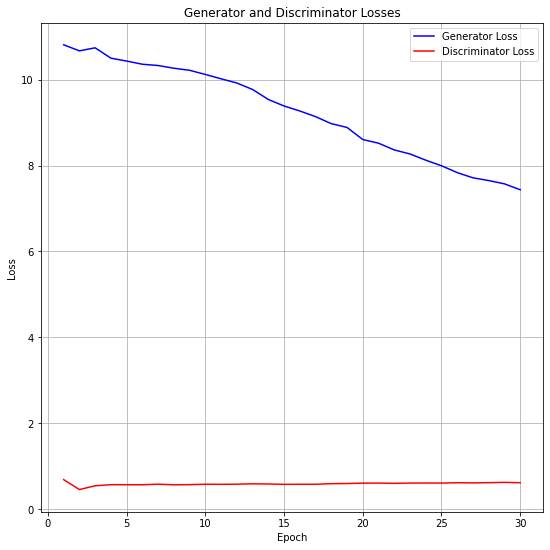

In [52]:
train_model(model, train_dataloader, epochs=30)

In [53]:
# Log the final mode in mlflow
mlflow.pytorch.log_model(model, "image_colorization")

2024/06/09 14:01:01 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.0+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [54]:
model_path = "models/colorization_model.pth"
torch.save(model.state_dict(), model_path)

In [78]:
model_path = "models/colorization_model.pth"
loaded_model = GANModel()
loaded_model = torch.load(model_path)

Model initialized with norm initialization
Model initialized with norm initialization


In [76]:
def visualize_in_test_image(model, data, save=False):
    """
    Visualizes the colorization results.

    Parameters:
        model: The colorization model.
        data: Input data for colorization.
        save (bool): Flag to save the visualization (default is True).
    """
    # nodel in evaluation mode
    model.net_G.eval()

    # disabiling the gradient
    with torch.no_grad():
        model.setup_input(data)
        model.forward()

    # forward pass
    model.net_G.train()

    # predicted by model
    fake_color = model.fake_color.detach()

    # real color of image
    real_color = model.ab

    # lightness channel of image
    L = model.L

    # conversion to rgb
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)

    # plotting the figure
    fig = plt.figure(figsize=(15, 15))
    plt.tight_layout()

    # Adjust padding between subplots
    plt.subplots_adjust(wspace=0.1, hspace=0.1) 
    for i in range(4):
        ax = plt.subplot(4, 3, i * 3 + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        
        ax = plt.subplot(4, 3, i * 3 + 2)
        ax.imshow(real_imgs[i])
        ax.axis("off")
        
        ax = plt.subplot(4, 3, i * 3 + 3)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
    
    plt.show()

In [108]:
def load_image(path: str):
   # Read the image using OpenCV
    image = cv2.imread(str(path))

    # Convert the image from BGR (OpenCV format) to RGB (PIL format)
    image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Apply transformations to the image
    transform = transforms.Resize((IMAGE_DIM, IMAGE_DIM), Image.BICUBIC)

    img = transform(image)
    img = np.array(img)  # Convert the PIL image to a NumPy array

    # Convert the RGB image to L*a*b color space
    img_lab = rgb2lab(img).astype("float32")
    img_lab = transforms.ToTensor()(img_lab)  # Convert the L*a*b image to a tensor

    # Normalize the Lightness channel to be between -1 and 1
    Lightness_channel = img_lab[[0], ...] / 50.0 - 1.0

    # Normalize the a and b channels to be between -1 and 1
    ab_channel = img_lab[[1, 2], ...] / 110.0

    # Return the Lightness and ab channels as a dictionary
    data = {'L': Lightness_channel.unsqueeze(0), 'ab': ab_channel.unsqueeze(0)} 

    return data

In [109]:
def plot_on_single_image(model, data):
    # nodel in evaluation mode
    model.net_G.eval()

    # disabiling the gradient
    with torch.no_grad():
        model.setup_input(data)
        model.forward()

    # forward pass
    model.net_G.train()

    # predicted by model
    fake_color = model.fake_color.detach()

    # real color of image
    real_color = model.ab

    # lightness channel of image
    L = model.L

    # conversion to rgb
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)

    # plotting the figure
    fig = plt.figure(figsize=(15, 15))
    plt.tight_layout()

    # Adjust padding between subplots
    plt.subplots_adjust(wspace=0.1, hspace=0.1) 

    ax = plt.subplot(1, 2, 1)
    ax.imshow(cv2.cvtColor(real_imgs[0], cv2.COLOR_BGR2GRAY), cmap="gray")
    ax.axis("off")

    ax = plt.subplot(1, 2, 2)
    ax.imshow(fake_imgs[0])
    ax.axis("off")

    plt.show()

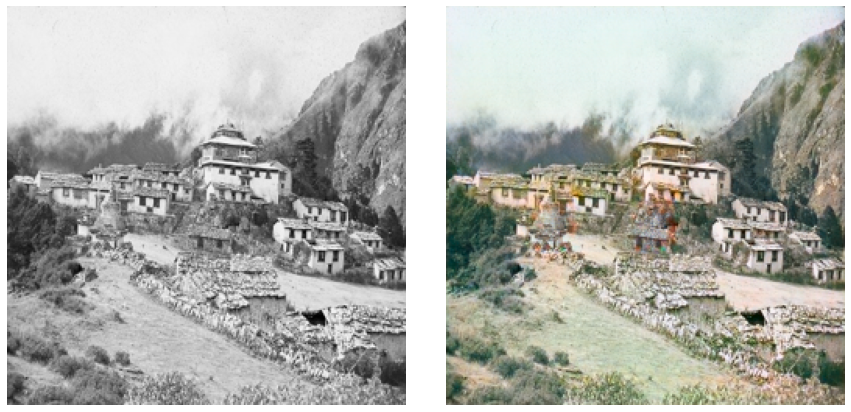

In [111]:
data = load_image(path="Dataset/test_images/image_49.jpg")
plot_on_single_image(model=model, data=data)

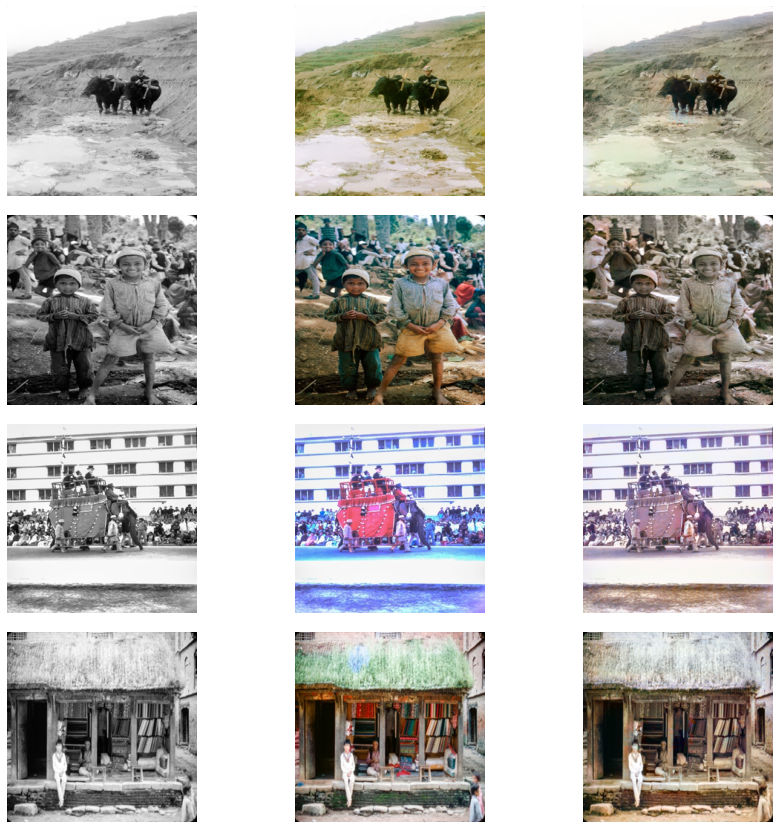

In [81]:
visualize_in_test_image(model, next(iter(test_dataloader)))